In [ ]:
import os
import zipfile
import shutil
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Paths
zip_path = '/content/drive/MyDrive/ISBI2016_ISIC_Part3B_Training_Data.zip'
extract_path = '/content/ISIC_extracted'
jpg_save_path = '/content/drive/MyDrive/ISIC_JPGs'
png_save_path = '/content/drive/MyDrive/ISIC_PNGs'

# Clean and create folders
for folder in [jpg_save_path, png_save_path]:
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder)

# Extract ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print(f"✅ Extracted to: {extract_path}")

# Move JPG and PNG files to respective folders
jpg_count = 0
png_count = 0
for root, _, files in os.walk(extract_path):
    for file in files:
        if file.lower().endswith('.jpg'):
            shutil.copy(os.path.join(root, file), os.path.join(jpg_save_path, file))
            jpg_count += 1
        elif file.lower().endswith('.png'):
            shutil.copy(os.path.join(root, file), os.path.join(png_save_path, file))
            png_count += 1

print(f"✅ {jpg_count} JPG files copied to: {jpg_save_path}")
print(f"✅ {png_count} PNG files copied to: {png_save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Extracted to: /content/ISIC_extracted
✅ 900 JPG files copied to: /content/drive/MyDrive/ISIC_JPGs
✅ 900 PNG files copied to: /content/drive/MyDrive/ISIC_PNGs


🧮 Total image pairs to check: 900


/tmp/ipython-input-1295915244.py:56: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


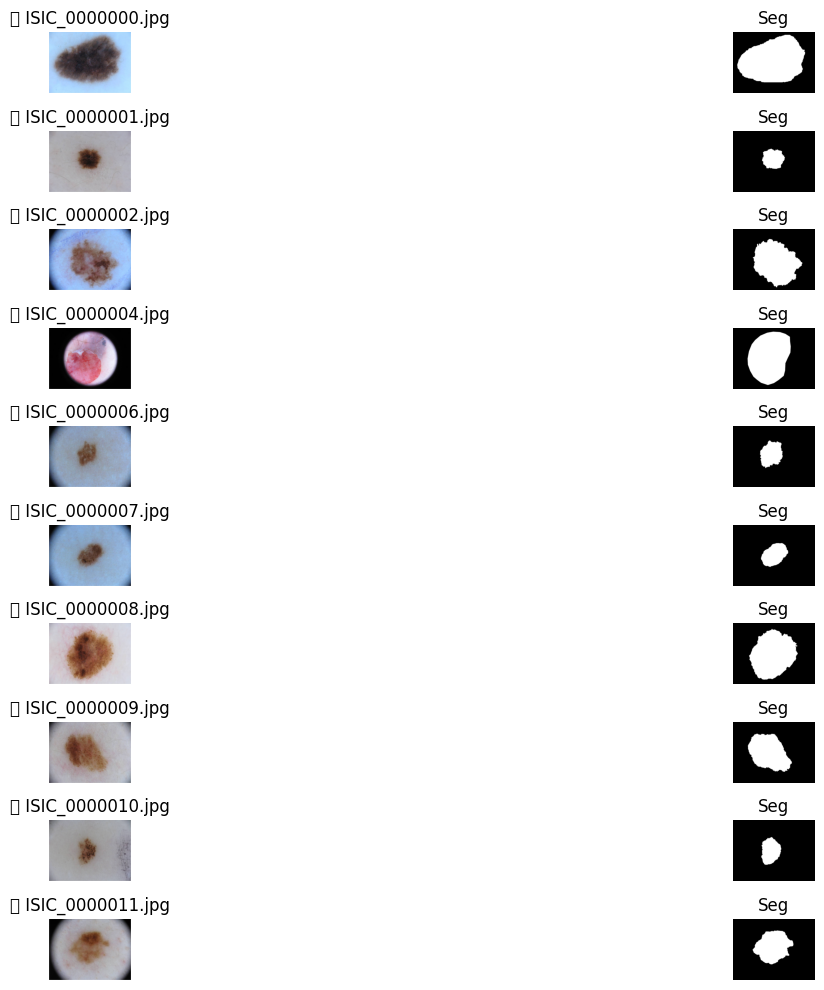

✅ No mismatches in this batch.


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Your image folders
jpg_folder = '/content/drive/MyDrive/ISIC_JPGs'
png_folder = '/content/drive/MyDrive/ISIC_PNGs'

# List all files
jpg_files = sorted([f for f in os.listdir(jpg_folder) if f.lower().endswith('.jpg')])
png_files = sorted([f for f in os.listdir(png_folder) if f.lower().endswith('.png')])

# Ensure same number of files
total = min(len(jpg_files), len(png_files))
print(f"🧮 Total image pairs to check: {total}")

def show_image_batch(batch_num=0, batch_size=20):
    start = batch_num * batch_size
    end = min(start + batch_size, total)

    mismatches = []

    plt.figure(figsize=(20, batch_size))
    for idx, i in enumerate(range(start, end)):
        jpg_path = os.path.join(jpg_folder, jpg_files[i])
        png_path = os.path.join(png_folder, png_files[i])

        img_jpg = cv2.imread(jpg_path)
        img_png = cv2.imread(png_path)

        if img_jpg is None or img_png is None:
            print(f"🚫 Failed to load: {jpg_files[i]} or {png_files[i]}")
            continue

        # Check size mismatch
        if img_jpg.shape[:2] != img_png.shape[:2]:
            mismatches.append((i, jpg_files[i], img_jpg.shape, img_png.shape))
            title = f"❌ {jpg_files[i]}"
        else:
            title = f"✅ {jpg_files[i]}"

        # Convert from BGR to RGB
        img_rgb = cv2.cvtColor(img_jpg, cv2.COLOR_BGR2RGB)
        plt.subplot(batch_size, 2, 2 * idx + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(title)

        img_mask = cv2.cvtColor(img_png, cv2.COLOR_BGR2RGB)
        plt.subplot(batch_size, 2, 2 * idx + 2)
        plt.imshow(img_mask)
        plt.axis('off')
        plt.title("Seg")

    plt.tight_layout()
    plt.show()

    if mismatches:
        print(f"\n❗ Mismatched images in this batch:")
        for item in mismatches:
            print(f"[{item[0]}] {item[1]} - JPG: {item[2]} vs PNG: {item[3]}")
    else:
        print("✅ No mismatches in this batch.")

# Run this for the first batch
show_image_batch(batch_num=0, batch_size=10)  # You can change to batch_num=1,2,... to see more


In [ ]:
import os
import shutil
import pandas as pd

# === PATHS ===
csv_path = '/content/drive/MyDrive/ISBI2016_ISIC_Part3B_Training_GroundTruth.csv'
jpg_folder = '/content/drive/MyDrive/ISIC_JPGs'
png_folder = '/content/drive/MyDrive/ISIC_PNGs'

# === OUTPUT FOLDERS ===
sorted_jpg_folder = '/content/drive/MyDrive/Sorted_JPGs'
sorted_png_folder = '/content/drive/MyDrive/Sorted_PNGs'

# Create output directories
for folder in [sorted_jpg_folder, sorted_png_folder]:
    for cls in ['benign', 'malignant']:
        os.makedirs(os.path.join(folder, cls), exist_ok=True)

# === READ CSV ===
df = pd.read_csv(csv_path, sep='\t', header=None, names=['image_name', 'type'])

# Drop rows with missing values
df = df.dropna()

# Make sure both columns are strings
df['image_name'] = df['image_name'].astype(str)
df['type'] = df['type'].astype(str)

# === PROCESS IMAGES ===
for idx, row in df.iterrows():
    img_name = row['image_name'].strip()
    img_type = row['type'].strip().lower()

    # File paths
    jpg_src = os.path.join(jpg_folder, f"{img_name}.jpg")
    png_src = os.path.join(png_folder, f"{img_name}.png")

    jpg_dest = os.path.join(sorted_jpg_folder, img_type, f"{img_name}.jpg")
    png_dest = os.path.join(sorted_png_folder, img_type, f"{img_name}.png")

    # Copy if exists
    if os.path.exists(jpg_src):
        shutil.copy2(jpg_src, jpg_dest)
    else:
        print(f"❌ JPG not found: {jpg_src}")

    if os.path.exists(png_src):
        shutil.copy2(png_src, png_dest)
    else:
        print(f"❌ PNG not found: {png_src}")


In [ ]:
import os
import shutil
import pandas as pd
from tqdm import tqdm

# --- Paths ---
csv_path = "/content/drive/MyDrive/ISBI2016_ISIC_Part3B_Training_GroundTruth.csv"
image_dir = "/content/drive/MyDrive/ISIC_JPGs"  # Actual image folder
output_dir = "/content/drive/MyDrive/ISIC_Separated"

# --- Create output directories ---
benign_dir = os.path.join(output_dir, "benign")
malignant_dir = os.path.join(output_dir, "malignant")
os.makedirs(benign_dir, exist_ok=True)
os.makedirs(malignant_dir, exist_ok=True)

# --- Load CSV ---
df = pd.read_csv(csv_path, header=None)
df.columns = ["image_id", "label"]  # Explicitly rename columns for clarity

# --- Track missing images ---
missing_images = []

# --- Copy images ---
print("Separating images into benign and malignant folders...\n")

for _, row in tqdm(df.iterrows(), total=len(df)):
    img_id = row["image_id"]
    label = row["label"].strip().lower()  # ensure consistency
    src_path = os.path.join(image_dir, img_id + ".jpg")

    if not os.path.exists(src_path):
        missing_images.append(src_path)
        continue

    if label == "benign":
        dst_path = os.path.join(benign_dir, img_id + ".jpg")
    elif label == "malignant":
        dst_path = os.path.join(malignant_dir, img_id + ".jpg")
    else:
        continue  # skip unknown labels

    shutil.copy2(src_path, dst_path)

# --- Report missing images ---
print(f"\n✅ Completed. Total missing images: {len(missing_images)}")
if missing_images:
    print("\nSome images were not found:")
    for m in missing_images[:10]:  # Show only first 10 for brevity
        print("Image not found:", m)


Separating images into benign and malignant folders...



100%|██████████| 900/900 [00:36<00:00, 24.89it/s]


✅ Completed. Total missing images: 0


In [ ]:
import os
import shutil
import pandas as pd
from tqdm import tqdm

# --- Paths ---
csv_path = "/content/drive/MyDrive/ISBI2016_ISIC_Part3B_Training_GroundTruth.csv"
seg_image_dir = "/content/drive/MyDrive/ISIC_PNGs"  # PNG segmentation folder
output_seg_dir = "/content/drive/MyDrive/ISIC_Separated_Segmentations"

# --- Create output directories ---
benign_seg_dir = os.path.join(output_seg_dir, "benign")
malignant_seg_dir = os.path.join(output_seg_dir, "malignant")
os.makedirs(benign_seg_dir, exist_ok=True)
os.makedirs(malignant_seg_dir, exist_ok=True)

# --- Load CSV ---
df = pd.read_csv(csv_path, header=None)
df.columns = ["image_id", "label"]

# --- Track missing segmentations ---
missing_segs = []

# --- Copy segmentation masks ---
print("Separating segmentation masks into benign and malignant folders...\n")

for _, row in tqdm(df.iterrows(), total=len(df)):
    img_id = row["image_id"]
    label = row["label"].strip().lower()

    seg_filename = img_id + "_Segmentation.png"
    src_path = os.path.join(seg_image_dir, seg_filename)

    if not os.path.exists(src_path):
        missing_segs.append(src_path)
        continue

    if label == "benign":
        dst_path = os.path.join(benign_seg_dir, seg_filename)
    elif label == "malignant":
        dst_path = os.path.join(malignant_seg_dir, seg_filename)
    else:
        continue  # unknown label

    shutil.copy2(src_path, dst_path)

# --- Report missing masks ---
print(f"\n✅ Completed. Total missing segmentation masks: {len(missing_segs)}")
if missing_segs:
    print("\nSome segmentations were not found:")
    for m in missing_segs[:10]:  # Show first 10
        print("Segmentation not found:", m)


Separating segmentation masks into benign and malignant folders...



100%|██████████| 900/900 [00:23<00:00, 37.81it/s] 


✅ Completed. Total missing segmentation masks: 0
